In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader

import numpy as np

from torchvision import datasets
from torchvision.transforms import Normalize

from src.discriminator import Discriminator
from src.generator import Generator
from src.gan_trainer import GANTrainer
from src.utils import GANType, generate_2d_normal_prior

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load data, create DataLoader

In [2]:
# Download the MNIST dataset.
mnist_dataset = datasets.MNIST(root='./.data/mnist_data/', train=True, download=True)

In [3]:
# Preprocess dataset (cast to float, normalize, and reshape/flatten samples)
def preprocess_dataset(dataset):
    dataset = dataset.float()
    normalized_dataset = Normalize(0.5, 0.5)(dataset)
    reshaped_dataset = normalized_dataset.reshape(dataset.shape[0], -1)
    return reshaped_dataset

preprocessed_dataset = preprocess_dataset(mnist_dataset.data)

TypeError: Input tensor should be a float tensor. Got torch.uint8.

In [4]:
# Create training dataloader
batch_size = 128
dataloader = DataLoader(dataset=preprocessed_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# Check if dataloader is correct
batch_of_data = next(iter(dataloader))
feature_dim = batch_of_data.shape[1]

print("Example of batch:")
print(batch_of_data)

print("\nFeature space size:")
print(feature_dim)

Example of batch:
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

Feature space size:
784


# Initialize and train GAN

In [26]:
# Hyperparameters
prior_size = 100
dropout = 0.0
leaky_relu_slope = 0.2
learning_rate = 0.0001

In [27]:
# Initialize components
generator = Generator(prior_size, feature_dim, dropout, leaky_relu_slope=leaky_relu_slope)
discriminator = Discriminator(feature_dim, dropout, leaky_relu_slope, discriminator_type=GANType.GAN)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

prior_generation_function = generate_2d_normal_prior

trainer = GANTrainer(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, prior_size, prior_generation_function, DEVICE)

In [45]:
# Train GAN
n_epochs = 5000
n_generator = 2
n_discriminator = 1

trainer.train(n_epochs, n_generator, n_discriminator)

[07:36<00:00,10.94it/s]100%|██████████[5000/5000]: Generator loss: 5.444, Discriminator loss: 0.005


# Analysis of training and results

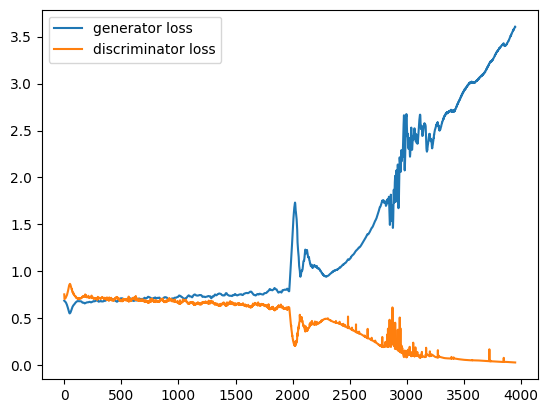

In [37]:
import matplotlib.pyplot as plt

# Plot loss graphs
plt.plot(trainer.g_losses, label="generator loss")
plt.plot(trainer.d_losses, label="discriminator loss")
plt.legend()

In [38]:
# Plot synthetic samples
number_of_samples_to_generate = 50
synthetic_samples = trainer.generate_n_samples(number_of_samples_to_generate).reshape(number_of_samples_to_generate, 28, 28)

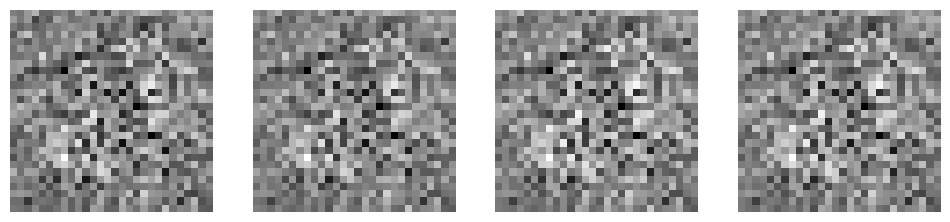

In [43]:
indices = np.random.choice(number_of_samples_to_generate, size=4, replace=False)

# Step 2: Plot the images corresponding to the indices
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, idx in enumerate(indices):
    image = synthetic_samples[idx]
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.show()